# Question 1

In this question we will:

- Implement a segmentation algorithm that uses random walker as the primary means to segment a noisy version of the leaf dataset from the previous assignment.
- Evaluate the performance of our algorithm in terms of mean Dice coefficient.
- Examine the best and worst results that we get from the dataset.
- Reason on why the algorithm works well on the 'best' cases and what causes it to fail on the 'worst' cases.



# Step 1: Write your Segmentation Algorithm

Write a function that segments a leaf image, and returns a binary (`dtype='bool'`) image representing the segmentation.  You may add additional parameters besides the image to be segmented if you wish.  Your algorithm must use the random-walker segmentation (``skimage.segmentation.random_walker()``) and you should consider doing some region processing after segmentation to improve the result.

Let's assume that, for the purposes of this, that de-noising the images would be too expensive because
our application has to run on a mobile device.   Thus, you are not allowed to denoise the images before applying the
random walker algorithm.

_Hint: The challenge here is to automatically find suitable foreground and background markers for the random walker algorithm.  The noisy images make for an additional challenge, but that's why we're using random walker; becuase of its robustness to noise._

_Hint: When you use `random_walker()` on a color image, make sure to set `channel_axis=2`._

_Hint: you may need to adjust the `beta` and `tol` arguments to the `ramdom_walker()` function to get excellent results._

_Hint: Output of the `random_walker()` function may be further post-processed using region processing methods._

In [50]:
import numpy as np
from scipy.ndimage import uniform_filter, binary_erosion  # local stats + conservative seeds
from scipy.ndimage import binary_fill_holes
from skimage import morphology, measure
from skimage.segmentation import random_walker

def segleaf(I, win= 7, p_fg=90, p_bg=50, frac_fg=0.65, frac_bg=0.35, 
            beta=150, tol=1e-2, min_size=100, hole_area=100):
    R, G, B = I[:, :, 0], I[:, :, 1], I[:, :, 2]

    # ExG
    S = R + G + B + 1e-8
    r, g, b = R / S, G / S, B / S
    exg_c = 2.0 * g - r - b

    # local statistics for robustness to pixel noise
    F = exg_c
    F_mean = uniform_filter(F.astype(np.float32), size=win, mode='reflect')
    green_dom = (G >= R) & (G >= B)
    green_frac = uniform_filter(green_dom.astype(np.float32), size=win, mode='reflect')  # local green fraction [web:77]

    # percentile thresholds computed on local mean
    hi = np.percentile(F_mean, p_fg)
    lo = np.percentile(F_mean, p_bg)

    # initial seeds from local consensus
    fg_seed = (F_mean >= hi) & (green_frac >= frac_fg) & green_dom
    bg_seed = (F_mean <= lo) & (green_frac <= frac_bg)

    # make seeds conservative (erode to avoid boundaries)
    fg_seed = binary_erosion(fg_seed, iterations=1)  # shrink to strong cores [web:82]
    bg_seed = binary_erosion(bg_seed, iterations=1)  # shrink to strong cores [web:82]

    # ensure seeds exist
    if fg_seed.sum() == 0:
        fg_seed = (F_mean >= np.percentile(F_mean, 99)) & (green_frac >= 0.6) & green_dom
    if bg_seed.sum() == 0:
        bg_seed = (F_mean <= np.percentile(F_mean, 1))

    # markers: 0=unknown, 1=leaf, 2=background
    markers = np.zeros(F.shape, dtype=np.int32)
    markers[fg_seed] = 1
    markers[bg_seed] = 2

    # Random walk to assign labels
    labels = random_walker(I, markers, beta=beta, tol=tol, channel_axis=2)

    # final binary mask from RW labels
    mask = (labels == 1)

    # Cleanup
    mask = morphology.remove_small_objects(mask, min_size=min_size)
    mask = morphology.remove_small_holes(mask, area_threshold=hole_area) 
    lbl = measure.label(mask, connectivity=2)
    if lbl.max() > 0:
        cnt = np.bincount(lbl.ravel()); cnt[0] = 0
        mask = (lbl == np.argmax(cnt))
    mask = binary_fill_holes(mask)

    return mask, markers


209
0.8196078431372549
(592, 896, 3)
uint8
(592, 896)
uint8
bool


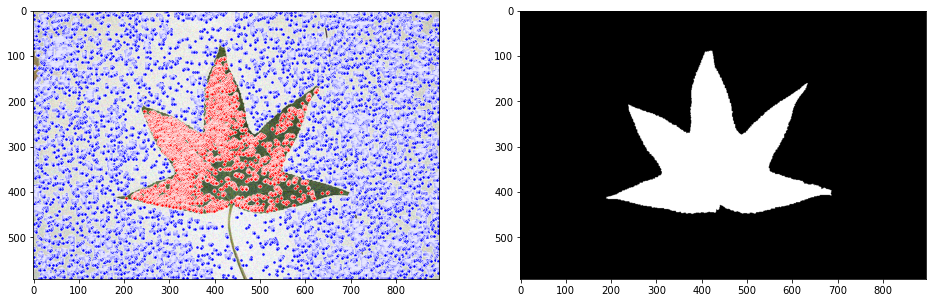

In [51]:
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.util import img_as_float

test_img = imread("noisyimages\image_0001.png")

print(test_img[...,0][0,0])
print(img_as_float(test_img[...,0][0,0]))

gtruth_img = imread("groundtruth\image_0001.png")
print(test_img.shape)
print(test_img.dtype)
print(gtruth_img.shape)
print(gtruth_img.dtype)

mask, markers = segleaf(img_as_float(test_img))
print(mask.dtype)

leafX, leafY = np.nonzero(markers==1)
bgX, bgY = np.nonzero(markers==2)

fig,ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(test_img)
ax[0].scatter(leafY, leafX, c='red', s=10, marker='o', 
              linewidths=0.5, edgecolors='white', label='FG seeds', alpha=0.9)
ax[0].scatter(bgY, bgX, c='blue', s=10, marker='o', 
              linewidths=0.5, edgecolors='white', label='FG seeds', alpha=0.9)
ax[1].imshow(mask, cmap='gray')

# Step 2: Write a Validation driver program.

Write code that segments each image, and computes the DSC for each segmentation.  Print the DSC of each segmentation as you perform it.  At the end, print the average of the DSC over all of the images. 

The general approach should be similar to Assignment 3.  For each input image (in the `noisyimages` directory):

* load the noisy image and it's ground truth
* segment the input image using the function you wrote in Step 1.
* Compute the DSC from the segmented image and the ground truth image (this function is given below).
* Print the DSC to the console.

When finished, print the average DSC for all images.  If you're getting a mean DSC of greater than 0.85, you're doing pretty good.

_Feel free to define additional helper functions for your program if you think it will help._

In [55]:
import pandas as pd
from skimage.io import imread
from skimage.util import img_as_float

def dice(seg, gt):
    seg = seg.astype(bool)
    gt  = gt.astype(bool)
    inter = np.logical_and(seg, gt).sum()
    denom = seg.sum() + gt.sum()
    return (2.0 * inter) / (denom + 1e-8)

files = pd.read_csv("images.csv", header=None)
png_list = files[0].tolist()

images = [img_as_float(imread(f"noisyimages\{png}")) for png in png_list] # Colour images of leaves
groundtruths = [img_as_float(imread(f"groundtruth\{png}")) > 0.5 for png in png_list] # Boolean mask of ground truths

segments = [segleaf(image) for image in images] # Boolean mask of leave images made by my algorithm

dscs = [dice(segment[0], groundtruth) for segment, groundtruth in zip(segments, groundtruths)] # List of dice values

recognized = [dsc > 0.6 for dsc in dscs]  # List of booleans stating whether a leaf was or wasnt recognized (ie dsc was > 0.6)

for fname, dsc in zip(png_list, dscs):
    print(f"DSC for {fname}: {dsc}")
    print(" - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

print(f"The mean Dice coefficient was: {np.mean(dscs)}")
print(f"The std. deviation of Dice coefficient was: {np.std(dscs)}")
print(f"{np.mean(recognized)*100}% of leaves were recognized")

c:\Users\predi\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


DSC for image_0001.png: 0.9887223224536008
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0002.png: 0.9727090738243402
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0005.png: 0.9898508185311229
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0007.png: 0.9101357576919109
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0009.png: 0.9686274752704621
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0010.png: 0.9916739941177652
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC for image_0011.png: 0.9902261447700516
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
DSC fo

# Step 3:  Display Examples

Choose one input image where your algoirthm performed very well.  Choose another image where the algorithm did not perform well.  Display the two original images with the segmentation superimposed on top (just like Step 4 in of assignment 3).  Also display the same two image's ground truth with the segmentation superimposed on top.    Title the images to indicate which is the "good" example, and which is the "bad" example.


In [2]:
import matplotlib.pyplot as plt


# Step 4: Reflection

### Answer the following questions right here in this block.

1. In a few sentences, briefly explain what your segmentation algorithm from Step 1 does and how it works.  

	_Your answer:_  

2. Consider your good result.  What, if anything, about your algoirthm is preventing you from getting a better result with this image?  If you weren't able to get any results, leave this blank, or explain what was preventing you from getting a result.

	_Your answer:_  

3. Consider your bad result.  What is it about your algoirthm caused the poor performance on this image?   If you weren't able to get any results, leave this blank.

	_Your answer:_ ("The images are noisy" is not an acceptable answer.  Be more specific -- if noise is the problem, explain why your algorithm can't overcome the noise; what is preventing it, or what does it need to do better to succeed?)
